In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc
from sklearn.neighbors import KNeighborsClassifier

import scipy
from scipy import spatial

from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
# # https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch
# #try add l1 tregularisation

# loss = loss_fn(outputs, labels)
# l1_lambda = 0.001
# l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())

# loss = loss + l1_lambda * l1_norm

In [3]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get data

In [4]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)

In [5]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [6]:
with open('../datasets/ready2use/style_emb_pl.npy', 'rb') as f:
    emb_style = np.load(f)

In [7]:
embeddings_table = pd.read_csv('../datasets/ready2use/embeddings_pl_herbert.csv', sep=",", header=None).values
embeddings_table.shape

(6541, 1024)

In [8]:
with open('../datasets/ready2use/embeddings_pl_herbert_aug.npy', 'rb') as f:
    embeddings_table_aug = np.load(f)

embeddings_table_aug.shape

(65410, 1024)

In [9]:
# embeddings_table = np.concatenate([embeddings_table, emb_style],1)
# embeddings_table.shape

In [10]:
# X_pos = pd.read_csv('../datasets/ready2use/pos_pl_dataset.csv', sep=';')
# del X_pos['assestment']
# print( X_pos.shape )

# corr_score = []
# for c in X_pos.columns:
#     min_v = X_pos[c].values[train_index].min()
#     max_v = X_pos[c].values[train_index].max()

#     if min_v < max_v:
#         r = scipy.stats.pearsonr(X_pos[c].values[train_index], y_train)[0]
#         if ~np.isnan(r):
#             corr_score.append(r)
#         else:
#             corr_score.append(0)
#     else:
#         corr_score.append(0)
        
        
# embeddings_table = X_pos.values[ :, np.argsort(corr_score)[-1024:] ]
# embeddings_table.shape

## Kfold

In [11]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [12]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Train

## TripletLoss

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [14]:
class TripletLossVector():
    def __init__(self, margin=1.0):
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def get_loss(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        
        return losses

## Dataloader

In [15]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use, factor=1):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.repeat( [np.arange(index_to_use.shape[0])], factor, axis=0).reshape(-1)
        
        self.idx = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx): 
        item = self.index[idx]
                
        anchor_label = self.labels[item]

        positive_list = self.idx[self.idx!=item][self.labels[self.idx!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.idx[self.idx!=item][self.labels[self.idx!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

class FakeNewsLabel(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        
        anchor_claim = self.emb[item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, anchor_label

In [16]:
def prepare_loaders(emb_tab=None, 
                    emb_tab_train=None,
                    y_column=None, 
                    batch_size=512,
                    index_llist = [None],
                    sizes=10,
                    n_workers=8
                   ):
    train_index, val_index, test_index = index_llist
    
    train_index_more = np.concatenate([train_index.reshape(-1, 1)*10+i for i in range(10)], 1).T
    np.random.shuffle(train_index_more)
    train_index_more = train_index_more.T[:,:sizes].reshape(-1)
            
    train_ds = FakeNews(emb_tab_train, np.repeat(y_column, 10), train_index_more, 1)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    train_ds_label = FakeNewsLabel(emb_tab, y_column, train_index)
    train_loader_label = DataLoader(train_ds_label, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    val_ds = FakeNews(emb_tab, y_column, val_index, 1)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    test_ds = FakeNewsLabel(emb_tab, y_column, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    
    return train_loader, train_loader_label, val_loader, test_loader

## Define Net

In [22]:
class Network(nn.Module):
    def __init__(self, emb_dim=128, in_shape=1024, dropout=0.5):
        super(Network, self).__init__()
        
        self.in_shape = in_shape
        
        self.fc = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, self.in_shape)
        x = self.fc(x)
        return x
    
    
class Network_leaky(nn.Module):
    def __init__(self, emb_dim=128, in_shape=1024, dropout=0.5):
        super(Network_leaky, self).__init__()
        
        self.in_shape = in_shape
        
        self.fc = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, self.in_shape)
        x = self.fc(x)
        return x
    
class Network_sig(nn.Module):
    def __init__(self, emb_dim=128, in_shape=1024, dropout=0.5):
        super(Network_sig, self).__init__()
        
        self.in_shape = in_shape
        
        self.fc = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, self.in_shape)
        x = self.fc(x)
        return x

## Training loop

In [23]:
def train_loop(
    model=None,
    train_loader=None,
    val_loader=None,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=None,
    l1=None,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_X.pt'
):
    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
            positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
            negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)
            
            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            
#             if l1:
#                 l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
#                 loss = loss + l1 * l1_norm
                
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())
        model.eval()
        
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
            positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
            negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'models/{model_name}')

        if epoch%n_print == 0:
            print(f"{n_model} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")


In [24]:
train_index, val_index, test_index = cv_Kfold_i[np.random.randint(10)]

In [25]:
train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
    emb_tab=embeddings_table, 
    emb_tab_train=embeddings_table_aug,
    y_column=df['assestment'].values, 
    batch_size=512,
    index_llist = [train_index, val_index, test_index],
    sizes= 5,
    n_workers=8
)

## L2

In [27]:
# testign leaky ReLU and others
model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
    l1=0,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 7.5570;  Val Loss: 1.2656 Best Val loss 1.2656


KeyboardInterrupt: 

## L1

In [24]:
model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=0),
    l1=1e-5,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 7.3231;  Val Loss: 1.2549 Best Val loss 1.2549
0 Epoch: 101/1000 - Train Loss: 1.0044;  Val Loss: 1.0053 Best Val loss 0.9492
0 Epoch: 201/1000 - Train Loss: 0.1962;  Val Loss: 0.9815 Best Val loss 0.8883
0 Epoch: 301/1000 - Train Loss: 0.0771;  Val Loss: 1.0299 Best Val loss 0.8883
0 Epoch: 401/1000 - Train Loss: 0.0382;  Val Loss: 0.9551 Best Val loss 0.8883
0 Epoch: 501/1000 - Train Loss: 0.0248;  Val Loss: 0.9378 Best Val loss 0.8883
0 Epoch: 601/1000 - Train Loss: 0.0363;  Val Loss: 0.9681 Best Val loss 0.8883
0 Epoch: 701/1000 - Train Loss: 0.0257;  Val Loss: 0.9473 Best Val loss 0.8883
0 Epoch: 801/1000 - Train Loss: 0.0249;  Val Loss: 0.9492 Best Val loss 0.8883
0 Epoch: 901/1000 - Train Loss: 0.0180;  Val Loss: 0.9462 Best Val loss 0.8883


## Both

In [25]:
model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=2*1e-4, weight_decay=1e-5),
    l1=1e-5,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.4267;  Val Loss: 1.3073 Best Val loss 1.3073
0 Epoch: 101/1000 - Train Loss: 0.6228;  Val Loss: 0.9686 Best Val loss 0.9037
0 Epoch: 201/1000 - Train Loss: 0.0791;  Val Loss: 0.9795 Best Val loss 0.9037
0 Epoch: 301/1000 - Train Loss: 0.0423;  Val Loss: 0.9590 Best Val loss 0.9037
0 Epoch: 401/1000 - Train Loss: 0.0385;  Val Loss: 0.9295 Best Val loss 0.9037
0 Epoch: 501/1000 - Train Loss: 0.0306;  Val Loss: 0.9525 Best Val loss 0.9037
0 Epoch: 601/1000 - Train Loss: 0.0296;  Val Loss: 0.9417 Best Val loss 0.9037
0 Epoch: 701/1000 - Train Loss: 0.0203;  Val Loss: 0.9469 Best Val loss 0.9037
0 Epoch: 801/1000 - Train Loss: 0.0202;  Val Loss: 0.9873 Best Val loss 0.9037
0 Epoch: 901/1000 - Train Loss: 0.0212;  Val Loss: 0.9752 Best Val loss 0.9037


In [26]:
# bigger lr

model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=2*1e-3, weight_decay=1e-5),
    l1=1e-5,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 3.1203;  Val Loss: 0.9646 Best Val loss 0.9646
0 Epoch: 101/1000 - Train Loss: 0.1159;  Val Loss: 0.9786 Best Val loss 0.9140
0 Epoch: 201/1000 - Train Loss: 0.0628;  Val Loss: 0.9855 Best Val loss 0.8986
0 Epoch: 301/1000 - Train Loss: 0.0445;  Val Loss: 0.9988 Best Val loss 0.8648
0 Epoch: 401/1000 - Train Loss: 0.0347;  Val Loss: 0.9725 Best Val loss 0.8648
0 Epoch: 501/1000 - Train Loss: 0.0378;  Val Loss: 0.9764 Best Val loss 0.8648
0 Epoch: 601/1000 - Train Loss: 0.0345;  Val Loss: 0.9496 Best Val loss 0.8648
0 Epoch: 701/1000 - Train Loss: 0.0296;  Val Loss: 0.9665 Best Val loss 0.8648
0 Epoch: 801/1000 - Train Loss: 0.0414;  Val Loss: 0.9918 Best Val loss 0.8648
0 Epoch: 901/1000 - Train Loss: 0.0421;  Val Loss: 0.9903 Best Val loss 0.8648


In [27]:
# greater regularization components with greater lr

model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=2*1e-3, weight_decay=1e-4),
    l1=1e-4,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 3.1115;  Val Loss: 1.0324 Best Val loss 1.0324
0 Epoch: 101/1000 - Train Loss: 0.1422;  Val Loss: 0.9792 Best Val loss 0.9191
0 Epoch: 201/1000 - Train Loss: 0.1173;  Val Loss: 0.9615 Best Val loss 0.9062
0 Epoch: 301/1000 - Train Loss: 0.1007;  Val Loss: 0.9707 Best Val loss 0.9062
0 Epoch: 401/1000 - Train Loss: 0.0855;  Val Loss: 0.9879 Best Val loss 0.9062
0 Epoch: 501/1000 - Train Loss: 0.0866;  Val Loss: 0.9901 Best Val loss 0.9062
0 Epoch: 601/1000 - Train Loss: 0.0942;  Val Loss: 0.9969 Best Val loss 0.9062
0 Epoch: 701/1000 - Train Loss: 0.0867;  Val Loss: 0.9987 Best Val loss 0.9062
0 Epoch: 801/1000 - Train Loss: 0.0783;  Val Loss: 0.9985 Best Val loss 0.9062
0 Epoch: 901/1000 - Train Loss: 0.0774;  Val Loss: 0.9996 Best Val loss 0.9062


In [28]:
# use more data
train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
    emb_tab=embeddings_table, 
    emb_tab_train=embeddings_table_aug,
    y_column=df['assestment'].values, 
    batch_size=512,
    index_llist = [train_index, val_index, test_index],
    sizes=10,
    n_workers=8
)

model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=2*1e-5, weight_decay=1e-5),
    l1=1e-5,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

0 Epoch: 1/5000 - Train Loss: 8.2223;  Val Loss: 1.6316 Best Val loss 1.6316
0 Epoch: 101/5000 - Train Loss: 1.0058;  Val Loss: 1.0099 Best Val loss 0.9512
0 Epoch: 201/5000 - Train Loss: 0.9247;  Val Loss: 0.9409 Best Val loss 0.9100
0 Epoch: 301/5000 - Train Loss: 0.6750;  Val Loss: 0.9409 Best Val loss 0.8772
0 Epoch: 401/5000 - Train Loss: 0.3214;  Val Loss: 0.9778 Best Val loss 0.8772
0 Epoch: 501/5000 - Train Loss: 0.1572;  Val Loss: 0.9827 Best Val loss 0.8772
0 Epoch: 601/5000 - Train Loss: 0.0904;  Val Loss: 0.9665 Best Val loss 0.8772
0 Epoch: 701/5000 - Train Loss: 0.0579;  Val Loss: 0.9658 Best Val loss 0.8772
0 Epoch: 801/5000 - Train Loss: 0.0403;  Val Loss: 0.9691 Best Val loss 0.8772
0 Epoch: 901/5000 - Train Loss: 0.0327;  Val Loss: 0.9843 Best Val loss 0.8772
0 Epoch: 1001/5000 - Train Loss: 0.0286;  Val Loss: 0.9615 Best Val loss 0.8772
0 Epoch: 1101/5000 - Train Loss: 0.0220;  Val Loss: 0.9720 Best Val loss 0.8772
0 Epoch: 1201/5000 - Train Loss: 0.0203;  Val Loss: 

In [29]:
model = Network(100,embeddings_table.shape[1]).to(device)

train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=2*1e-5, weight_decay=1e-6),
    l1=1e-6,
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_XXX.pt'
)

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

0 Epoch: 1/5000 - Train Loss: 8.4510;  Val Loss: 1.9545 Best Val loss 1.9545
0 Epoch: 101/5000 - Train Loss: 1.0170;  Val Loss: 0.9842 Best Val loss 0.9484
0 Epoch: 201/5000 - Train Loss: 0.9412;  Val Loss: 0.9102 Best Val loss 0.9102
0 Epoch: 301/5000 - Train Loss: 0.6945;  Val Loss: 0.9763 Best Val loss 0.9050
0 Epoch: 401/5000 - Train Loss: 0.3255;  Val Loss: 0.9803 Best Val loss 0.9050
0 Epoch: 501/5000 - Train Loss: 0.1585;  Val Loss: 0.9725 Best Val loss 0.9050
0 Epoch: 601/5000 - Train Loss: 0.0890;  Val Loss: 0.9624 Best Val loss 0.9050
0 Epoch: 701/5000 - Train Loss: 0.0590;  Val Loss: 0.9466 Best Val loss 0.9050
0 Epoch: 801/5000 - Train Loss: 0.0422;  Val Loss: 0.9684 Best Val loss 0.9050
0 Epoch: 901/5000 - Train Loss: 0.0300;  Val Loss: 0.9679 Best Val loss 0.9050
0 Epoch: 1001/5000 - Train Loss: 0.0267;  Val Loss: 0.9627 Best Val loss 0.9050
0 Epoch: 1101/5000 - Train Loss: 0.0235;  Val Loss: 0.9608 Best Val loss 0.9050
0 Epoch: 1201/5000 - Train Loss: 0.0207;  Val Loss: 

KeyboardInterrupt: 

### Load model

In [52]:
model = torch.load('models/model_XX.pt')

In [53]:
train_results = []
labels = []

if_norm = False

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(train_loader_label):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/11 [00:00<?, ?it/s]

(5232, 20)

In [54]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(test_loader):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/2 [00:00<?, ?it/s]

(654, 20)

In [55]:
reducer_nn = umap.UMAP()
scaler_nn = StandardScaler().fit(train_results)

umap_nn_train = train_results if True else reducer_nn.fit_transform(train_results)
umap_nn_test = test_results if True else reducer_nn.transform(test_results)

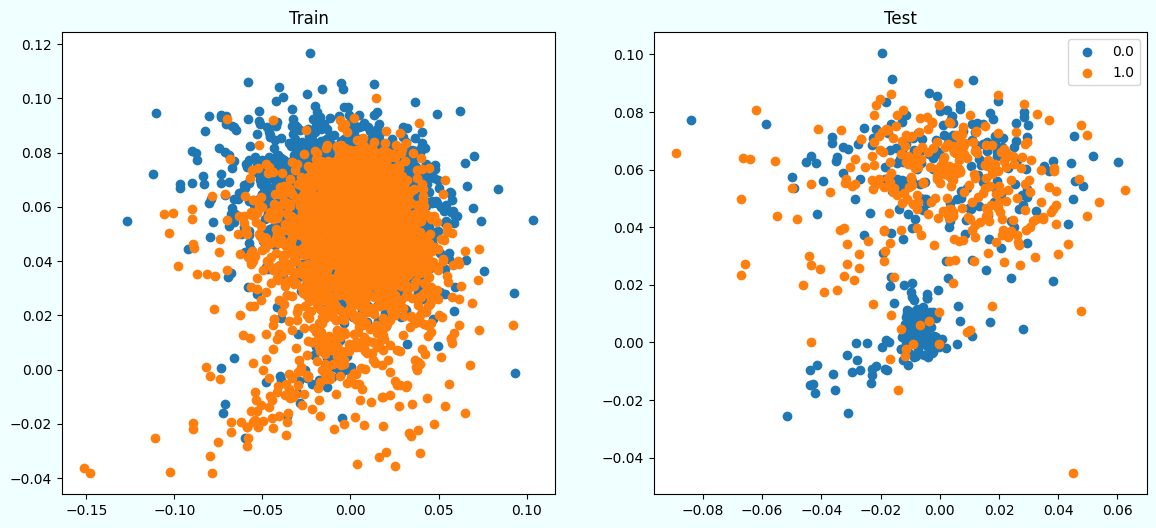

In [56]:
plt.figure(figsize=(14, 6), facecolor="azure")

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    tmp = umap_nn_train[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')

plt.subplot(1, 2, 2)
for label in np.unique(test_labels):
    tmp = umap_nn_test[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

In [57]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [58]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [59]:
confusion_matrix(y_test_t, y_pred)

array([[237, 100],
       [ 98, 219]])

In [60]:
metrics

{'Accuracy': array([0.69724771]), 'F1 Score': array([0.68867925])}

# Test using CV

In [28]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 512
epochs = 1000
n_workers = 8

for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
        emb_tab=embeddings_table, 
        emb_tab_train=embeddings_table_aug,
        y_column=df['assestment'].values, 
        batch_size=batch_size,
        index_llist = [train_index, val_index, test_index],
        sizes= [10,3],
        n_workers=n_workers
    )
    
    model = Network(embedding_dims)
    model = model.to(device)
    
    if_norm = False 
    
    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=1000,
        n_print=100,
        if_norm=if_norm,
        optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
        criterion=TripletLoss(),
        n_model=j,
        model_name='model_X.pt'
    )
    
    model = torch.load('models/model_X.pt')
    
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(train_loader_label):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)

    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)
    train_results.shape

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(test_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)

    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)
    test_results.shape

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.5345;  Val Loss: 1.2993 Best Val loss 1.2993
0 Epoch: 101/1000 - Train Loss: 0.3581;  Val Loss: 0.5225 Best Val loss 0.5225
0 Epoch: 201/1000 - Train Loss: 0.0521;  Val Loss: 0.4065 Best Val loss 0.4024
0 Epoch: 301/1000 - Train Loss: 0.0261;  Val Loss: 0.4140 Best Val loss 0.3967
0 Epoch: 401/1000 - Train Loss: 0.0191;  Val Loss: 0.4168 Best Val loss 0.3605
0 Epoch: 501/1000 - Train Loss: 0.0148;  Val Loss: 0.4195 Best Val loss 0.3586
0 Epoch: 601/1000 - Train Loss: 0.0131;  Val Loss: 0.4066 Best Val loss 0.3586
0 Epoch: 701/1000 - Train Loss: 0.0121;  Val Loss: 0.4092 Best Val loss 0.3419
0 Epoch: 801/1000 - Train Loss: 0.0106;  Val Loss: 0.3746 Best Val loss 0.3360
0 Epoch: 901/1000 - Train Loss: 0.0094;  Val Loss: 0.4010 Best Val loss 0.3360


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

1 Epoch: 1/1000 - Train Loss: 6.2847;  Val Loss: 1.2688 Best Val loss 1.2688
1 Epoch: 101/1000 - Train Loss: 0.3520;  Val Loss: 0.6069 Best Val loss 0.5931
1 Epoch: 201/1000 - Train Loss: 0.0528;  Val Loss: 0.5675 Best Val loss 0.4764
1 Epoch: 301/1000 - Train Loss: 0.0276;  Val Loss: 0.5088 Best Val loss 0.4647
1 Epoch: 401/1000 - Train Loss: 0.0208;  Val Loss: 0.5275 Best Val loss 0.4647
1 Epoch: 501/1000 - Train Loss: 0.0187;  Val Loss: 0.5472 Best Val loss 0.4647
1 Epoch: 601/1000 - Train Loss: 0.0142;  Val Loss: 0.5377 Best Val loss 0.4647
1 Epoch: 701/1000 - Train Loss: 0.0119;  Val Loss: 0.5587 Best Val loss 0.4647
1 Epoch: 801/1000 - Train Loss: 0.0105;  Val Loss: 0.5708 Best Val loss 0.4647
1 Epoch: 901/1000 - Train Loss: 0.0107;  Val Loss: 0.5488 Best Val loss 0.4647


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

2 Epoch: 1/1000 - Train Loss: 6.5368;  Val Loss: 1.2520 Best Val loss 1.2520
2 Epoch: 101/1000 - Train Loss: 0.3970;  Val Loss: 0.9334 Best Val loss 0.9150
2 Epoch: 201/1000 - Train Loss: 0.0589;  Val Loss: 0.7416 Best Val loss 0.7345
2 Epoch: 301/1000 - Train Loss: 0.0330;  Val Loss: 0.7322 Best Val loss 0.7100
2 Epoch: 401/1000 - Train Loss: 0.0248;  Val Loss: 0.7015 Best Val loss 0.6484
2 Epoch: 501/1000 - Train Loss: 0.0199;  Val Loss: 0.7099 Best Val loss 0.6484
2 Epoch: 601/1000 - Train Loss: 0.0178;  Val Loss: 0.7555 Best Val loss 0.6484
2 Epoch: 701/1000 - Train Loss: 0.0176;  Val Loss: 0.7813 Best Val loss 0.6484
2 Epoch: 801/1000 - Train Loss: 0.0139;  Val Loss: 0.8316 Best Val loss 0.6484
2 Epoch: 901/1000 - Train Loss: 0.0140;  Val Loss: 0.8629 Best Val loss 0.6484


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

3 Epoch: 1/1000 - Train Loss: 6.4012;  Val Loss: 1.2417 Best Val loss 1.2417
3 Epoch: 101/1000 - Train Loss: 0.4014;  Val Loss: 0.7025 Best Val loss 0.6753
3 Epoch: 201/1000 - Train Loss: 0.0528;  Val Loss: 0.5162 Best Val loss 0.5024
3 Epoch: 301/1000 - Train Loss: 0.0295;  Val Loss: 0.5703 Best Val loss 0.5024
3 Epoch: 401/1000 - Train Loss: 0.0217;  Val Loss: 0.5386 Best Val loss 0.4900
3 Epoch: 501/1000 - Train Loss: 0.0175;  Val Loss: 0.6044 Best Val loss 0.4900
3 Epoch: 601/1000 - Train Loss: 0.0147;  Val Loss: 0.5729 Best Val loss 0.4900
3 Epoch: 701/1000 - Train Loss: 0.0127;  Val Loss: 0.6331 Best Val loss 0.4900
3 Epoch: 801/1000 - Train Loss: 0.0121;  Val Loss: 0.5988 Best Val loss 0.4900
3 Epoch: 901/1000 - Train Loss: 0.0107;  Val Loss: 0.6629 Best Val loss 0.4900


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

4 Epoch: 1/1000 - Train Loss: 6.2920;  Val Loss: 1.2748 Best Val loss 1.2748
4 Epoch: 101/1000 - Train Loss: 0.3781;  Val Loss: 0.5390 Best Val loss 0.5253
4 Epoch: 201/1000 - Train Loss: 0.0511;  Val Loss: 0.3871 Best Val loss 0.3724
4 Epoch: 301/1000 - Train Loss: 0.0248;  Val Loss: 0.4137 Best Val loss 0.3515
4 Epoch: 401/1000 - Train Loss: 0.0211;  Val Loss: 0.3968 Best Val loss 0.3515
4 Epoch: 501/1000 - Train Loss: 0.0156;  Val Loss: 0.4101 Best Val loss 0.3493
4 Epoch: 601/1000 - Train Loss: 0.0127;  Val Loss: 0.3484 Best Val loss 0.3427
4 Epoch: 701/1000 - Train Loss: 0.0123;  Val Loss: 0.3666 Best Val loss 0.3278
4 Epoch: 801/1000 - Train Loss: 0.0108;  Val Loss: 0.3541 Best Val loss 0.3274
4 Epoch: 901/1000 - Train Loss: 0.0092;  Val Loss: 0.3608 Best Val loss 0.3274


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

5 Epoch: 1/1000 - Train Loss: 6.4546;  Val Loss: 1.0554 Best Val loss 1.0554
5 Epoch: 101/1000 - Train Loss: 0.3662;  Val Loss: 0.9467 Best Val loss 0.9383
5 Epoch: 201/1000 - Train Loss: 0.0591;  Val Loss: 0.8172 Best Val loss 0.7755
5 Epoch: 301/1000 - Train Loss: 0.0383;  Val Loss: 0.7257 Best Val loss 0.6891
5 Epoch: 401/1000 - Train Loss: 0.0273;  Val Loss: 0.7184 Best Val loss 0.6891
5 Epoch: 501/1000 - Train Loss: 0.0237;  Val Loss: 0.7777 Best Val loss 0.6891
5 Epoch: 601/1000 - Train Loss: 0.0188;  Val Loss: 0.8225 Best Val loss 0.6891
5 Epoch: 701/1000 - Train Loss: 0.0180;  Val Loss: 0.8624 Best Val loss 0.6891
5 Epoch: 801/1000 - Train Loss: 0.0169;  Val Loss: 0.8854 Best Val loss 0.6891
5 Epoch: 901/1000 - Train Loss: 0.0149;  Val Loss: 0.9110 Best Val loss 0.6891


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

6 Epoch: 1/1000 - Train Loss: 6.3200;  Val Loss: 1.2337 Best Val loss 1.2337
6 Epoch: 101/1000 - Train Loss: 0.3675;  Val Loss: 0.5324 Best Val loss 0.5171
6 Epoch: 201/1000 - Train Loss: 0.0540;  Val Loss: 0.4280 Best Val loss 0.3764
6 Epoch: 301/1000 - Train Loss: 0.0304;  Val Loss: 0.4335 Best Val loss 0.3627
6 Epoch: 401/1000 - Train Loss: 0.0198;  Val Loss: 0.4094 Best Val loss 0.3464
6 Epoch: 501/1000 - Train Loss: 0.0175;  Val Loss: 0.3764 Best Val loss 0.3464
6 Epoch: 601/1000 - Train Loss: 0.0143;  Val Loss: 0.3613 Best Val loss 0.3462
6 Epoch: 701/1000 - Train Loss: 0.0130;  Val Loss: 0.3822 Best Val loss 0.3248
6 Epoch: 801/1000 - Train Loss: 0.0102;  Val Loss: 0.3810 Best Val loss 0.3220
6 Epoch: 901/1000 - Train Loss: 0.0099;  Val Loss: 0.3497 Best Val loss 0.3087


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

7 Epoch: 1/1000 - Train Loss: 6.0607;  Val Loss: 1.2702 Best Val loss 1.2702
7 Epoch: 101/1000 - Train Loss: 0.3393;  Val Loss: 0.5819 Best Val loss 0.5819
7 Epoch: 201/1000 - Train Loss: 0.0530;  Val Loss: 0.5019 Best Val loss 0.4674
7 Epoch: 301/1000 - Train Loss: 0.0282;  Val Loss: 0.5124 Best Val loss 0.4674
7 Epoch: 401/1000 - Train Loss: 0.0216;  Val Loss: 0.5315 Best Val loss 0.4674
7 Epoch: 501/1000 - Train Loss: 0.0174;  Val Loss: 0.5689 Best Val loss 0.4674
7 Epoch: 601/1000 - Train Loss: 0.0142;  Val Loss: 0.6164 Best Val loss 0.4674
7 Epoch: 701/1000 - Train Loss: 0.0128;  Val Loss: 0.6021 Best Val loss 0.4674
7 Epoch: 801/1000 - Train Loss: 0.0111;  Val Loss: 0.6230 Best Val loss 0.4674
7 Epoch: 901/1000 - Train Loss: 0.0108;  Val Loss: 0.6381 Best Val loss 0.4674


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

8 Epoch: 1/1000 - Train Loss: 6.1961;  Val Loss: 1.2423 Best Val loss 1.2423
8 Epoch: 101/1000 - Train Loss: 0.4273;  Val Loss: 0.5484 Best Val loss 0.5484
8 Epoch: 201/1000 - Train Loss: 0.0517;  Val Loss: 0.4241 Best Val loss 0.4004
8 Epoch: 301/1000 - Train Loss: 0.0288;  Val Loss: 0.4554 Best Val loss 0.3941
8 Epoch: 401/1000 - Train Loss: 0.0206;  Val Loss: 0.3986 Best Val loss 0.3822
8 Epoch: 501/1000 - Train Loss: 0.0164;  Val Loss: 0.4104 Best Val loss 0.3802
8 Epoch: 601/1000 - Train Loss: 0.0150;  Val Loss: 0.4176 Best Val loss 0.3802
8 Epoch: 701/1000 - Train Loss: 0.0137;  Val Loss: 0.4087 Best Val loss 0.3781
8 Epoch: 801/1000 - Train Loss: 0.0110;  Val Loss: 0.4236 Best Val loss 0.3781
8 Epoch: 901/1000 - Train Loss: 0.0090;  Val Loss: 0.4167 Best Val loss 0.3781


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

9 Epoch: 1/1000 - Train Loss: 6.5505;  Val Loss: 1.6671 Best Val loss 1.6671
9 Epoch: 101/1000 - Train Loss: 0.3768;  Val Loss: 0.6476 Best Val loss 0.6295
9 Epoch: 201/1000 - Train Loss: 0.0541;  Val Loss: 0.5650 Best Val loss 0.4974
9 Epoch: 301/1000 - Train Loss: 0.0312;  Val Loss: 0.5439 Best Val loss 0.4940
9 Epoch: 401/1000 - Train Loss: 0.0201;  Val Loss: 0.6011 Best Val loss 0.4940
9 Epoch: 501/1000 - Train Loss: 0.0174;  Val Loss: 0.5999 Best Val loss 0.4940
9 Epoch: 601/1000 - Train Loss: 0.0148;  Val Loss: 0.6508 Best Val loss 0.4940
9 Epoch: 701/1000 - Train Loss: 0.0129;  Val Loss: 0.6603 Best Val loss 0.4940
9 Epoch: 801/1000 - Train Loss: 0.0120;  Val Loss: 0.6719 Best Val loss 0.4940
9 Epoch: 901/1000 - Train Loss: 0.0097;  Val Loss: 0.6954 Best Val loss 0.4940


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.632+-0.086 F1 Score 0.643+-0.058  0.632+-0.086 | 0.643+-0.058


### Get use best models

In [29]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 512
epochs = 1000
n_workers = 8

for j, (train_index, val_index, test_index) in enumerate(cv_Kfold_i):
    train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
        emb_tab=embeddings_table, 
        emb_tab_train=embeddings_table_aug,
        y_column=df['assestment'].values, 
        batch_size=batch_size,
        index_llist = [train_index, val_index, test_index],
        sizes= [10,3],
        n_workers=n_workers
    )
    
    model = Network(embedding_dims)
    model = model.to(device)

    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=1000,
        n_print=100,
        if_norm=False,
        optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
        criterion=TripletLoss(),
        n_model=j,
        model_name='model_X.pt'
    )
    
    model = torch.load('models/model_X.pt')
    
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(train_loader_label):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)

    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)
    train_results.shape

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(test_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)

    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)
    test_results.shape

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.3884;  Val Loss: 1.9007 Best Val loss 1.9007
0 Epoch: 101/1000 - Train Loss: 0.3891;  Val Loss: 0.9855 Best Val loss 0.8902
0 Epoch: 201/1000 - Train Loss: 0.0582;  Val Loss: 0.9779 Best Val loss 0.8902
0 Epoch: 301/1000 - Train Loss: 0.0376;  Val Loss: 0.9464 Best Val loss 0.8902
0 Epoch: 401/1000 - Train Loss: 0.0238;  Val Loss: 0.9682 Best Val loss 0.8902
0 Epoch: 501/1000 - Train Loss: 0.0217;  Val Loss: 0.9791 Best Val loss 0.8902
0 Epoch: 601/1000 - Train Loss: 0.0170;  Val Loss: 0.9740 Best Val loss 0.8902
0 Epoch: 701/1000 - Train Loss: 0.0160;  Val Loss: 0.9897 Best Val loss 0.8902
0 Epoch: 801/1000 - Train Loss: 0.0134;  Val Loss: 0.9857 Best Val loss 0.8902
0 Epoch: 901/1000 - Train Loss: 0.0148;  Val Loss: 0.9831 Best Val loss 0.8902


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

1 Epoch: 1/1000 - Train Loss: 6.3172;  Val Loss: 1.6574 Best Val loss 1.6574
1 Epoch: 101/1000 - Train Loss: 0.3926;  Val Loss: 0.9777 Best Val loss 0.8955
1 Epoch: 201/1000 - Train Loss: 0.0641;  Val Loss: 0.9400 Best Val loss 0.8955
1 Epoch: 301/1000 - Train Loss: 0.0381;  Val Loss: 0.9419 Best Val loss 0.8955
1 Epoch: 401/1000 - Train Loss: 0.0233;  Val Loss: 0.9401 Best Val loss 0.8955
1 Epoch: 501/1000 - Train Loss: 0.0228;  Val Loss: 0.9538 Best Val loss 0.8955
1 Epoch: 601/1000 - Train Loss: 0.0213;  Val Loss: 0.9650 Best Val loss 0.8955
1 Epoch: 701/1000 - Train Loss: 0.0162;  Val Loss: 0.9859 Best Val loss 0.8955
1 Epoch: 801/1000 - Train Loss: 0.0169;  Val Loss: 0.9868 Best Val loss 0.8955
1 Epoch: 901/1000 - Train Loss: 0.0129;  Val Loss: 0.9408 Best Val loss 0.8955


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

2 Epoch: 1/1000 - Train Loss: 6.3902;  Val Loss: 1.5435 Best Val loss 1.5435
2 Epoch: 101/1000 - Train Loss: 0.3591;  Val Loss: 0.9712 Best Val loss 0.9004
2 Epoch: 201/1000 - Train Loss: 0.0582;  Val Loss: 0.9802 Best Val loss 0.9004
2 Epoch: 301/1000 - Train Loss: 0.0316;  Val Loss: 0.9568 Best Val loss 0.9004
2 Epoch: 401/1000 - Train Loss: 0.0276;  Val Loss: 0.9646 Best Val loss 0.9004
2 Epoch: 501/1000 - Train Loss: 0.0236;  Val Loss: 0.9582 Best Val loss 0.9004
2 Epoch: 601/1000 - Train Loss: 0.0174;  Val Loss: 0.9727 Best Val loss 0.9004
2 Epoch: 701/1000 - Train Loss: 0.0165;  Val Loss: 0.9836 Best Val loss 0.9004
2 Epoch: 801/1000 - Train Loss: 0.0129;  Val Loss: 0.9813 Best Val loss 0.9004
2 Epoch: 901/1000 - Train Loss: 0.0158;  Val Loss: 0.9898 Best Val loss 0.9004


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

3 Epoch: 1/1000 - Train Loss: 6.5950;  Val Loss: 1.8490 Best Val loss 1.8490
3 Epoch: 101/1000 - Train Loss: 0.4360;  Val Loss: 0.9549 Best Val loss 0.9094
3 Epoch: 201/1000 - Train Loss: 0.0674;  Val Loss: 0.9415 Best Val loss 0.9094
3 Epoch: 301/1000 - Train Loss: 0.0318;  Val Loss: 0.9999 Best Val loss 0.9094
3 Epoch: 401/1000 - Train Loss: 0.0280;  Val Loss: 0.9450 Best Val loss 0.9094
3 Epoch: 501/1000 - Train Loss: 0.0229;  Val Loss: 0.9693 Best Val loss 0.9094
3 Epoch: 601/1000 - Train Loss: 0.0167;  Val Loss: 0.9744 Best Val loss 0.9094
3 Epoch: 701/1000 - Train Loss: 0.0139;  Val Loss: 0.9699 Best Val loss 0.9094
3 Epoch: 801/1000 - Train Loss: 0.0153;  Val Loss: 0.9652 Best Val loss 0.9094
3 Epoch: 901/1000 - Train Loss: 0.0144;  Val Loss: 0.9671 Best Val loss 0.9094


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

4 Epoch: 1/1000 - Train Loss: 6.2080;  Val Loss: 1.8079 Best Val loss 1.8079
4 Epoch: 101/1000 - Train Loss: 0.3950;  Val Loss: 0.9660 Best Val loss 0.8754
4 Epoch: 201/1000 - Train Loss: 0.0554;  Val Loss: 0.9814 Best Val loss 0.8754
4 Epoch: 301/1000 - Train Loss: 0.0339;  Val Loss: 0.9514 Best Val loss 0.8754
4 Epoch: 401/1000 - Train Loss: 0.0253;  Val Loss: 0.9608 Best Val loss 0.8754
4 Epoch: 501/1000 - Train Loss: 0.0217;  Val Loss: 0.9500 Best Val loss 0.8754
4 Epoch: 601/1000 - Train Loss: 0.0182;  Val Loss: 0.9653 Best Val loss 0.8754
4 Epoch: 701/1000 - Train Loss: 0.0177;  Val Loss: 0.9862 Best Val loss 0.8754
4 Epoch: 801/1000 - Train Loss: 0.0152;  Val Loss: 0.9809 Best Val loss 0.8754
4 Epoch: 901/1000 - Train Loss: 0.0151;  Val Loss: 0.9780 Best Val loss 0.8754


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

5 Epoch: 1/1000 - Train Loss: 6.4177;  Val Loss: 1.6861 Best Val loss 1.6861
5 Epoch: 101/1000 - Train Loss: 0.3932;  Val Loss: 0.9715 Best Val loss 0.8958
5 Epoch: 201/1000 - Train Loss: 0.0601;  Val Loss: 0.9332 Best Val loss 0.8958
5 Epoch: 301/1000 - Train Loss: 0.0328;  Val Loss: 0.9656 Best Val loss 0.8958
5 Epoch: 401/1000 - Train Loss: 0.0252;  Val Loss: 0.9785 Best Val loss 0.8958
5 Epoch: 501/1000 - Train Loss: 0.0202;  Val Loss: 0.9672 Best Val loss 0.8958
5 Epoch: 601/1000 - Train Loss: 0.0193;  Val Loss: 0.9752 Best Val loss 0.8958
5 Epoch: 701/1000 - Train Loss: 0.0173;  Val Loss: 0.9698 Best Val loss 0.8958
5 Epoch: 801/1000 - Train Loss: 0.0173;  Val Loss: 0.9835 Best Val loss 0.8958
5 Epoch: 901/1000 - Train Loss: 0.0170;  Val Loss: 0.9958 Best Val loss 0.8958


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

6 Epoch: 1/1000 - Train Loss: 6.3121;  Val Loss: 1.7487 Best Val loss 1.7487
6 Epoch: 101/1000 - Train Loss: 0.3950;  Val Loss: 0.9709 Best Val loss 0.8732
6 Epoch: 201/1000 - Train Loss: 0.0579;  Val Loss: 0.9880 Best Val loss 0.8732
6 Epoch: 301/1000 - Train Loss: 0.0353;  Val Loss: 0.9770 Best Val loss 0.8732
6 Epoch: 401/1000 - Train Loss: 0.0299;  Val Loss: 0.9509 Best Val loss 0.8732
6 Epoch: 501/1000 - Train Loss: 0.0191;  Val Loss: 0.9382 Best Val loss 0.8732
6 Epoch: 601/1000 - Train Loss: 0.0185;  Val Loss: 0.9651 Best Val loss 0.8732
6 Epoch: 701/1000 - Train Loss: 0.0169;  Val Loss: 0.9715 Best Val loss 0.8732
6 Epoch: 801/1000 - Train Loss: 0.0148;  Val Loss: 0.9855 Best Val loss 0.8732
6 Epoch: 901/1000 - Train Loss: 0.0124;  Val Loss: 0.9855 Best Val loss 0.8732


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

7 Epoch: 1/1000 - Train Loss: 6.3049;  Val Loss: 1.3168 Best Val loss 1.3168
7 Epoch: 101/1000 - Train Loss: 0.4706;  Val Loss: 0.9721 Best Val loss 0.8839
7 Epoch: 201/1000 - Train Loss: 0.0597;  Val Loss: 0.9577 Best Val loss 0.8839
7 Epoch: 301/1000 - Train Loss: 0.0410;  Val Loss: 1.0170 Best Val loss 0.8839
7 Epoch: 401/1000 - Train Loss: 0.0277;  Val Loss: 0.9530 Best Val loss 0.8839
7 Epoch: 501/1000 - Train Loss: 0.0230;  Val Loss: 0.9843 Best Val loss 0.8839
7 Epoch: 601/1000 - Train Loss: 0.0207;  Val Loss: 0.9799 Best Val loss 0.8839
7 Epoch: 701/1000 - Train Loss: 0.0189;  Val Loss: 0.9828 Best Val loss 0.8839
7 Epoch: 801/1000 - Train Loss: 0.0167;  Val Loss: 0.9660 Best Val loss 0.8839
7 Epoch: 901/1000 - Train Loss: 0.0120;  Val Loss: 0.9934 Best Val loss 0.8839


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

8 Epoch: 1/1000 - Train Loss: 6.3966;  Val Loss: 1.9625 Best Val loss 1.9625
8 Epoch: 101/1000 - Train Loss: 0.4257;  Val Loss: 0.9813 Best Val loss 0.8853
8 Epoch: 201/1000 - Train Loss: 0.0651;  Val Loss: 0.9646 Best Val loss 0.8853
8 Epoch: 301/1000 - Train Loss: 0.0327;  Val Loss: 0.9806 Best Val loss 0.8853
8 Epoch: 401/1000 - Train Loss: 0.0274;  Val Loss: 0.9673 Best Val loss 0.8853
8 Epoch: 501/1000 - Train Loss: 0.0209;  Val Loss: 0.9686 Best Val loss 0.8853
8 Epoch: 601/1000 - Train Loss: 0.0181;  Val Loss: 0.9791 Best Val loss 0.8853
8 Epoch: 701/1000 - Train Loss: 0.0175;  Val Loss: 0.9918 Best Val loss 0.8853
8 Epoch: 801/1000 - Train Loss: 0.0143;  Val Loss: 0.9858 Best Val loss 0.8853
8 Epoch: 901/1000 - Train Loss: 0.0148;  Val Loss: 0.9959 Best Val loss 0.8853


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

9 Epoch: 1/1000 - Train Loss: 6.2506;  Val Loss: 1.5475 Best Val loss 1.5475
9 Epoch: 101/1000 - Train Loss: 0.3729;  Val Loss: 0.9775 Best Val loss 0.9006
9 Epoch: 201/1000 - Train Loss: 0.0614;  Val Loss: 0.9570 Best Val loss 0.9006
9 Epoch: 301/1000 - Train Loss: 0.0360;  Val Loss: 0.9685 Best Val loss 0.9006
9 Epoch: 401/1000 - Train Loss: 0.0248;  Val Loss: 0.9554 Best Val loss 0.9006
9 Epoch: 501/1000 - Train Loss: 0.0236;  Val Loss: 0.9541 Best Val loss 0.8950
9 Epoch: 601/1000 - Train Loss: 0.0175;  Val Loss: 0.9464 Best Val loss 0.8950
9 Epoch: 701/1000 - Train Loss: 0.0174;  Val Loss: 0.9746 Best Val loss 0.8950
9 Epoch: 801/1000 - Train Loss: 0.0142;  Val Loss: 0.9576 Best Val loss 0.8950
9 Epoch: 901/1000 - Train Loss: 0.0155;  Val Loss: 0.9640 Best Val loss 0.8950


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.667+-0.051 F1 Score 0.667+-0.035  0.667+-0.051 | 0.667+-0.035
